In [6]:
from datetime import datetime
import numpy as np
import pandas as pd
import random

In [39]:
N = 10
start_date = datetime(2022, 1, 2)

In [40]:
trades = pd.DataFrame({'side': (random.choice(["BUY", "SELL"]) for _ in range(N)), 
                      'volume': (random.choice([1e6, 2e6, 5e6]) for _ in range(N))}, 
                      index=start_date + pd.to_timedelta(np.arange(N), 'min'))
trades

,side,volume
2022-01-02 00:00:00,SELL,1000000.0
2022-01-02 00:01:00,SELL,1000000.0
2022-01-02 00:02:00,SELL,1000000.0
2022-01-02 00:03:00,SELL,1000000.0
2022-01-02 00:04:00,BUY,2000000.0
2022-01-02 00:05:00,BUY,5000000.0
2022-01-02 00:06:00,BUY,2000000.0
2022-01-02 00:07:00,SELL,1000000.0
2022-01-02 00:08:00,BUY,2000000.0
2022-01-02 00:09:00,BUY,5000000.0


In [41]:
def get_market_mids(start_rate, start_time, n, std, period):
    rate = start_rate * np.cumprod(np.random.normal(1, std, n))
    index = start_time + period[0] * pd.to_timedelta(np.arange(n), period[1])
    return pd.Series(rate, index=index, name='mid')

market_data = get_market_mids(1.05, datetime(2022, 1, 2), 200000, 0.00005, (5, 'ms'))
market_data = market_data.to_frame('mid')
market_data.tail()

,mid
2022-01-02 00:16:39.975,1.009669
2022-01-02 00:16:39.980,1.009736
2022-01-02 00:16:39.985,1.009672
2022-01-02 00:16:39.990,1.009687
2022-01-02 00:16:39.995,1.009772


<AxesSubplot:>

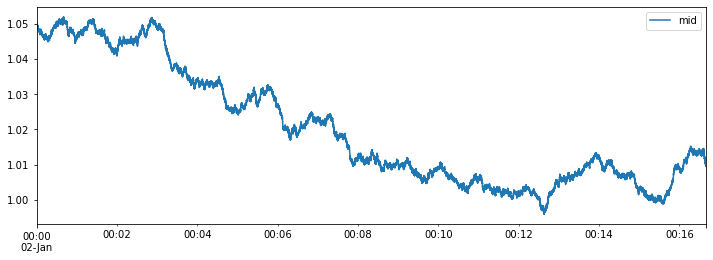

In [47]:
market_data.plot(figsize=(12, 4))

#### Get markouts

In [48]:
result = trades.copy()
for s in (0, 2, 5, 15, 60):
    result = pd.merge_asof(result, market_data.set_index(market_data.index - pd.to_timedelta(s, 'sec')), 
                           direction='backward', left_index=True, right_index=True)
    result.rename(columns={'mid': 'mid%ss' % s}, inplace=True)
result

,side,volume,mid0s,mid2s,mid5s,mid15s,mid60s
2022-01-02 00:00:00,SELL,1000000.0,1.050021,1.049210,1.047701,1.046075,1.046117
2022-01-02 00:01:00,SELL,1000000.0,1.046117,1.047024,1.047090,1.048457,1.041400
2022-01-02 00:02:00,SELL,1000000.0,1.041400,1.043565,1.045504,1.044586,1.048985
2022-01-02 00:03:00,SELL,1000000.0,1.048985,1.049352,1.048525,1.042089,1.034048
2022-01-02 00:04:00,BUY,2000000.0,1.034048,1.033421,1.032886,1.033523,1.024633
2022-01-02 00:05:00,BUY,5000000.0,1.024633,1.025379,1.026489,1.028425,1.026436
2022-01-02 00:06:00,BUY,2000000.0,1.026436,1.026295,1.024273,1.020362,1.022741
2022-01-02 00:07:00,SELL,1000000.0,1.022741,1.022634,1.021735,1.024147,1.012656
2022-01-02 00:08:00,BUY,2000000.0,1.012656,1.012261,1.011292,1.010869,1.010945
2022-01-02 00:09:00,BUY,5000000.0,1.010945,1.009273,1.010001,1.010675,1.009009


#### Get median (similar to Kdb window join)

In [57]:
median_time = 30
medians = []
for t in result.index:
    medians.append(market_data['mid'][t : (t + pd.to_timedelta(median_time, 'sec'))].median())
result['mid_median'] = medians
result

,side,volume,mid0s,mid2s,mid5s,mid15s,mid60s,mid_median
2022-01-02 00:00:00,SELL,1000000.0,1.050021,1.049210,1.047701,1.046075,1.046117,1.047242
2022-01-02 00:01:00,SELL,1000000.0,1.046117,1.047024,1.047090,1.048457,1.041400,1.048576
2022-01-02 00:02:00,SELL,1000000.0,1.041400,1.043565,1.045504,1.044586,1.048985,1.045015
2022-01-02 00:03:00,SELL,1000000.0,1.048985,1.049352,1.048525,1.042089,1.034048,1.042010
2022-01-02 00:04:00,BUY,2000000.0,1.034048,1.033421,1.032886,1.033523,1.024633,1.032972
2022-01-02 00:05:00,BUY,5000000.0,1.024633,1.025379,1.026489,1.028425,1.026436,1.027624
2022-01-02 00:06:00,BUY,2000000.0,1.026436,1.026295,1.024273,1.020362,1.022741,1.020187
2022-01-02 00:07:00,SELL,1000000.0,1.022741,1.022634,1.021735,1.024147,1.012656,1.022313
2022-01-02 00:08:00,BUY,2000000.0,1.012656,1.012261,1.011292,1.010869,1.010945,1.011591
2022-01-02 00:09:00,BUY,5000000.0,1.010945,1.009273,1.010001,1.010675,1.009009,1.009502
